### Rafly Fasha Purnomo Putra - 1103223050

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Load the dataset
df = pd.read_csv('/content/clusteringmidterm.csv')

# Initial exploration
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nDescriptive statistics:")
print(df.describe())
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (8950, 18)

First 5 rows:
  CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.08333

In [10]:
def preprocess_data(df):
    """Clean and preprocess the customer data"""

    # Create a copy to avoid modifying original
    df_clean = df.copy()

    # 1. Handle CUST_ID - store for reference, then drop for clustering
    cust_ids = df_clean['CUST_ID']
    df_clean = df_clean.drop('CUST_ID', axis=1)

    # 2. Handle missing values
    print("Missing values before imputation:")
    print(df_clean.isnull().sum())

    # Fill missing values with median (robust to outliers)
    for column in df_clean.columns:
        if df_clean[column].isnull().sum() > 0:
            df_clean[column].fillna(df_clean[column].median(), inplace=True)

    # 3. Handle outliers using IQR method
    def cap_outliers(series):
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return series.clip(lower_bound, upper_bound)

    # Apply to numeric columns
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        df_clean[col] = cap_outliers(df_clean[col])

    # 4. Feature engineering - create useful derived features
    df_clean['TOTAL_PURCHASES'] = df_clean['ONEOFF_PURCHASES'] + df_clean['INSTALLMENTS_PURCHASES']
    df_clean['PURCHASE_TO_BALANCE_RATIO'] = df_clean['PURCHASES'] / (df_clean['BALANCE'] + 1)
    df_clean['CASH_ADVANCE_TO_LIMIT_RATIO'] = df_clean['CASH_ADVANCE'] / (df_clean['CREDIT_LIMIT'] + 1)
    df_clean['PAYMENT_TO_MINPAYMENT_RATIO'] = df_clean['PAYMENTS'] / (df_clean['MINIMUM_PAYMENTS'] + 1)
    df_clean['UTILIZATION_RATE'] = df_clean['BALANCE'] / (df_clean['CREDIT_LIMIT'] + 1)

    # 5. Scale the data
    scaler = RobustScaler()  # Less sensitive to outliers than StandardScaler
    scaled_data = scaler.fit_transform(df_clean)

    return scaled_data, df_clean, cust_ids, scaler

# Apply preprocessing
scaled_data, df_clean, cust_ids, scaler = preprocess_data(df)
print(f"\nProcessed data shape: {scaled_data.shape}")

Missing values before imputation:
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Processed data shape: (8950, 22)


Explained variance ratio: [0.64501238 0.21650893]
Total explained variance: 86.15%


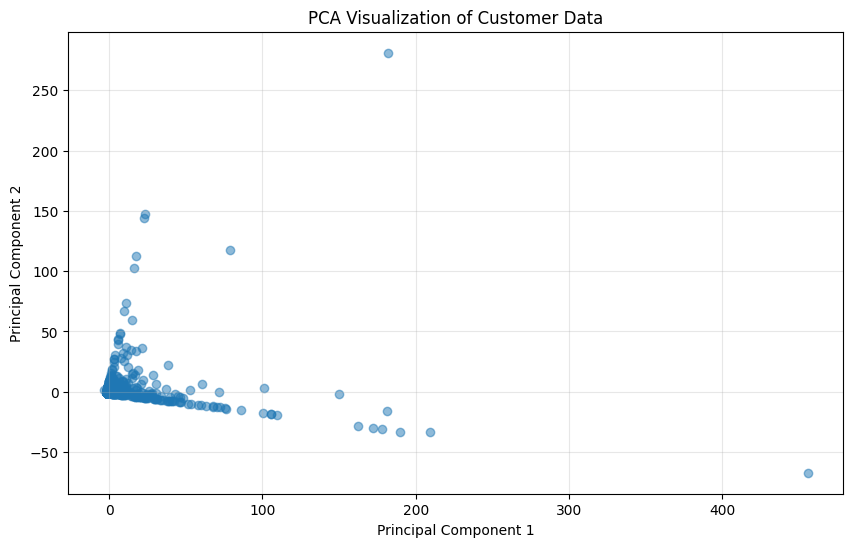

In [11]:
def apply_pca(data, n_components=2):
    """Apply PCA for visualization and dimensionality reduction"""
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(data)

    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2%}")

    return pca_result, pca

# Apply PCA
pca_result, pca_model = apply_pca(scaled_data)

# Visualize PCA results
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Customer Data')
plt.grid(True, alpha=0.3)
plt.show()

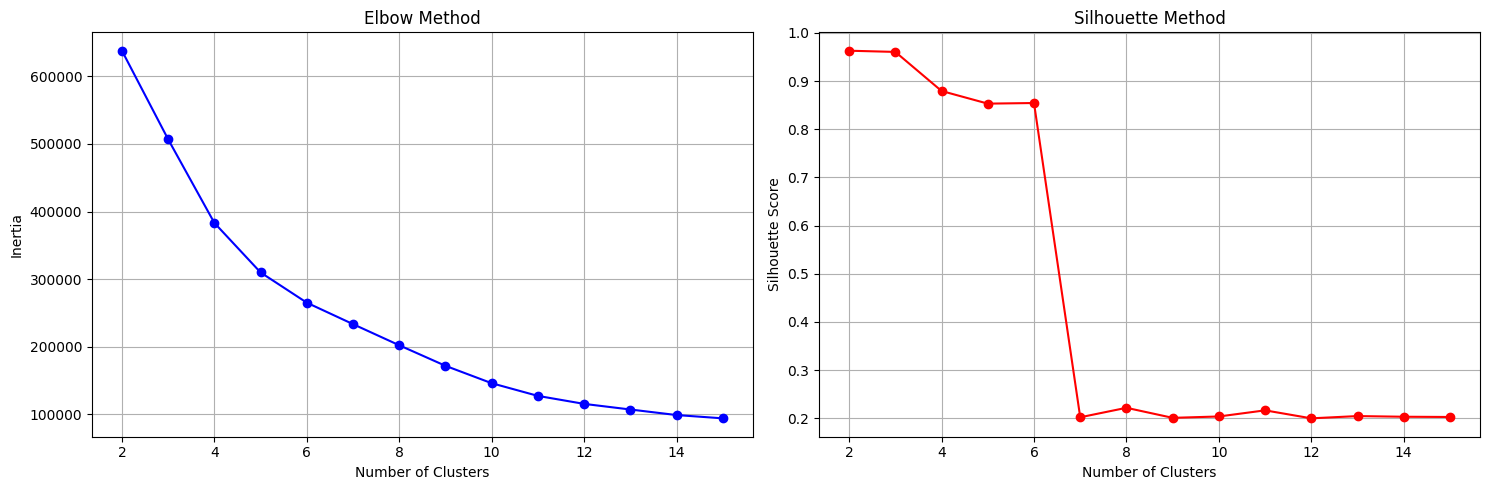

Suggested clusters by Elbow method: 2
Suggested clusters by Silhouette method: 2


In [12]:
def find_optimal_clusters(data, max_clusters=15):
    """Find optimal number of clusters using Elbow and Silhouette methods"""

    inertias = []
    silhouette_scores = []

    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)

        if len(set(kmeans.labels_)) > 1:  # Need at least 2 clusters for silhouette
            silhouette_scores.append(silhouette_score(data, kmeans.labels_))
        else:
            silhouette_scores.append(0)

    # Plot Elbow Method
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(range(2, max_clusters + 1), inertias, 'bo-')
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Inertia')
    ax1.set_title('Elbow Method')
    ax1.grid(True)

    # Plot Silhouette Scores
    ax2.plot(range(2, max_clusters + 1), silhouette_scores, 'ro-')
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Method')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Find optimal k
    optimal_k_elbow = np.argmin(np.diff(inertias)) + 2
    optimal_k_silhouette = np.argmax(silhouette_scores) + 2

    print(f"Suggested clusters by Elbow method: {optimal_k_elbow}")
    print(f"Suggested clusters by Silhouette method: {optimal_k_silhouette}")

    return optimal_k_silhouette

# Find optimal clusters
optimal_k = find_optimal_clusters(scaled_data)


In [13]:
def apply_clustering(data, n_clusters=4):
    """Apply different clustering algorithms"""

    results = {}

    # 1. K-Means Clustering
    print(f"\n{'='*50}")
    print("K-MEANS CLUSTERING")
    print(f"{'='*50}")

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
    kmeans_labels = kmeans.fit_predict(data)
    results['kmeans'] = {
        'labels': kmeans_labels,
        'model': kmeans,
        'inertia': kmeans.inertia_
    }

    # 2. Hierarchical Clustering
    print(f"\n{'='*50}")
    print("HIERARCHICAL CLUSTERING")
    print(f"{'='*50}")

    hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
    hierarchical_labels = hierarchical.fit_predict(data)
    results['hierarchical'] = {
        'labels': hierarchical_labels,
        'model': hierarchical
    }

    # 3. DBSCAN (automatically determines clusters)
    print(f"\n{'='*50}")
    print("DBSCAN CLUSTERING")
    print(f"{'='*50}")

    dbscan = DBSCAN(eps=0.5, min_samples=10)
    dbscan_labels = dbscan.fit_predict(data)
    results['dbscan'] = {
        'labels': dbscan_labels,
        'model': dbscan
    }

    # Evaluate each method
    for method in ['kmeans', 'hierarchical']:
        labels = results[method]['labels']
        if len(set(labels)) > 1:
            silhouette = silhouette_score(data, labels)
            db_index = davies_bouldin_score(data, labels)
            print(f"\n{method.upper()} Evaluation:")
            print(f"Silhouette Score: {silhouette:.3f}")
            print(f"Davies-Bouldin Index: {db_index:.3f}")

    # For DBSCAN
    n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    print(f"\nDBSCAN found {n_clusters_dbscan} clusters")
    print(f"Noise points: {list(dbscan_labels).count(-1)}")

    return results

# Apply clustering
clustering_results = apply_clustering(scaled_data, n_clusters=optimal_k)


K-MEANS CLUSTERING

HIERARCHICAL CLUSTERING

DBSCAN CLUSTERING

KMEANS Evaluation:
Silhouette Score: 0.963
Davies-Bouldin Index: 0.504

HIERARCHICAL Evaluation:
Silhouette Score: 0.969
Davies-Bouldin Index: 0.313

DBSCAN found 12 clusters
Noise points: 7981


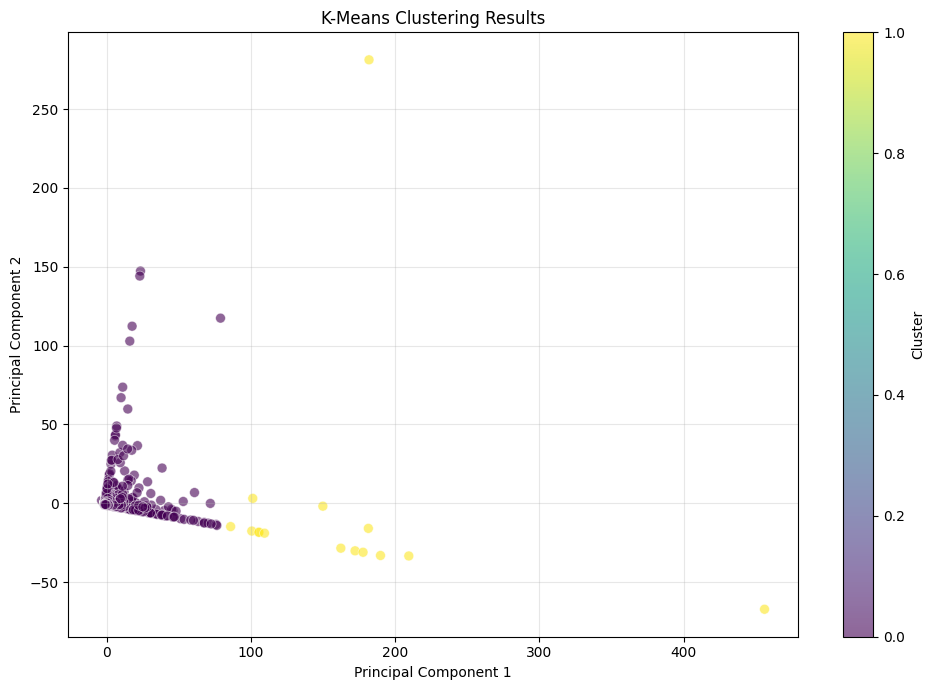


Cluster distribution for K-Means:
Cluster 0: 8935 customers (99.8%)
Cluster 1: 15 customers (0.2%)


In [14]:
def visualize_clusters(data, labels, algorithm_name):
    """Visualize clusters in 2D using PCA"""

    # Reduce to 2D for visualization
    pca_2d = PCA(n_components=2)
    data_2d = pca_2d.fit_transform(data)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1],
                         c=labels, cmap='viridis', alpha=0.6,
                         s=50, edgecolors='w', linewidth=0.5)

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'{algorithm_name} Clustering Results')
    plt.colorbar(scatter, label='Cluster')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Cluster sizes
    unique, counts = np.unique(labels, return_counts=True)
    print(f"\nCluster distribution for {algorithm_name}:")
    for cluster, count in zip(unique, counts):
        print(f"Cluster {cluster}: {count} customers ({count/len(labels)*100:.1f}%)")

# Visualize K-Means results
visualize_clusters(scaled_data, clustering_results['kmeans']['labels'], 'K-Means')

In [15]:
def interpret_clusters(df_original, labels, n_clusters):
    """Analyze and interpret what each cluster represents"""

    # Add cluster labels to original dataframe
    df_analysis = df_original.copy()
    df_analysis['CLUSTER'] = labels

    # Create summary statistics for each cluster
    cluster_profiles = {}

    for cluster in range(n_clusters):
        cluster_data = df_analysis[df_analysis['CLUSTER'] == cluster]

        profile = {
            'size': len(cluster_data),
            'percentage': len(cluster_data) / len(df_analysis) * 100,
            'characteristics': {}
        }

        # Calculate key metrics for each cluster
        key_features = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE',
                       'CREDIT_LIMIT', 'PAYMENTS', 'TENURE']

        for feature in key_features:
            profile['characteristics'][feature] = {
                'mean': cluster_data[feature].mean(),
                'median': cluster_data[feature].median(),
                'std': cluster_data[feature].std()
            }

        cluster_profiles[cluster] = profile

    # Print cluster interpretations
    print(f"\n{'='*60}")
    print("CLUSTER INTERPRETATIONS")
    print(f"{'='*60}")

    for cluster, profile in cluster_profiles.items():
        print(f"\n📊 CLUSTER {cluster} - {profile['size']} customers ({profile['percentage']:.1f}%)")
        print("-" * 40)

        # Determine cluster type based on characteristics
        balance_mean = profile['characteristics']['BALANCE']['mean']
        purchases_mean = profile['characteristics']['PURCHASES']['mean']
        cash_adv_mean = profile['characteristics']['CASH_ADVANCE']['mean']
        credit_limit = profile['characteristics']['CREDIT_LIMIT']['mean']
        payments = profile['characteristics']['PAYMENTS']['mean']

        # Business logic for interpretation
        if purchases_mean > df_analysis['PURCHASES'].mean() and balance_mean < df_analysis['BALANCE'].mean():
            cluster_type = "High Spenders / Good Payer"
            description = "Makes frequent purchases but maintains low balance. Likely pays off balances regularly."
        elif cash_adv_mean > df_analysis['CASH_ADVANCE'].mean():
            cluster_type = "Cash Advance Users"
            description = "Relies heavily on cash advances. May indicate financial stress."
        elif balance_mean > df_analysis['BALANCE'].mean() * 1.5:
            cluster_type = "High Balance / Risky"
            description = "Carries high outstanding balance. Higher credit risk."
        elif purchases_mean < df_analysis['PURCHASES'].mean() * 0.5:
            cluster_type = "Low Activity / Inactive"
            description = "Minimal card usage. May be dormant or infrequent users."
        else:
            cluster_type = "Average Users"
            description = "Moderate usage across all categories. Typical card users."

        print(f"Type: {cluster_type}")
        print(f"Description: {description}")

        # Print key statistics
        print("\nKey Statistics (mean values):")
        print(f"  • Balance: ${balance_mean:,.0f}")
        print(f"  • Purchases: ${purchases_mean:,.0f}")
        print(f"  • Cash Advances: ${cash_adv_mean:,.0f}")
        print(f"  • Credit Limit: ${credit_limit:,.0f}")
        print(f"  • Payments: ${payments:,.0f}")

        # Calculate derived metrics
        utilization = balance_mean / credit_limit if credit_limit > 0 else 0
        print(f"\nDerived Metrics:")
        print(f"  • Credit Utilization: {utilization:.1%}")
        print(f"  • Purchase to Balance Ratio: {purchases_mean/(balance_mean+1):.2f}")

    return df_analysis, cluster_profiles

# Interpret clusters
df_labeled, cluster_profiles = interpret_clusters(df_clean,
                                                 clustering_results['kmeans']['labels'],
                                                 optimal_k)


CLUSTER INTERPRETATIONS

📊 CLUSTER 0 - 8935 customers (99.8%)
----------------------------------------
Type: Cash Advance Users
Description: Relies heavily on cash advances. May indicate financial stress.

Key Statistics (mean values):
  • Balance: $1,393
  • Purchases: $737
  • Cash Advances: $674
  • Credit Limit: $4,421
  • Payments: $1,348

Derived Metrics:
  • Credit Utilization: 31.5%
  • Purchase to Balance Ratio: 0.53

📊 CLUSTER 1 - 15 customers (0.2%)
----------------------------------------
Type: High Spenders / Good Payer
Description: Makes frequent purchases but maintains low balance. Likely pays off balances regularly.

Key Statistics (mean values):
  • Balance: $0
  • Purchases: $1,078
  • Cash Advances: $0
  • Credit Limit: $3,487
  • Payments: $1,096

Derived Metrics:
  • Credit Utilization: 0.0%
  • Purchase to Balance Ratio: 886.83


CUSTOMER CLUSTERING PIPELINE

1. LOADING AND PREPROCESSING DATA...
Missing values before imputation:
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

2. DETERMINING OPTIMAL NUMBER OF CLUSTERS...


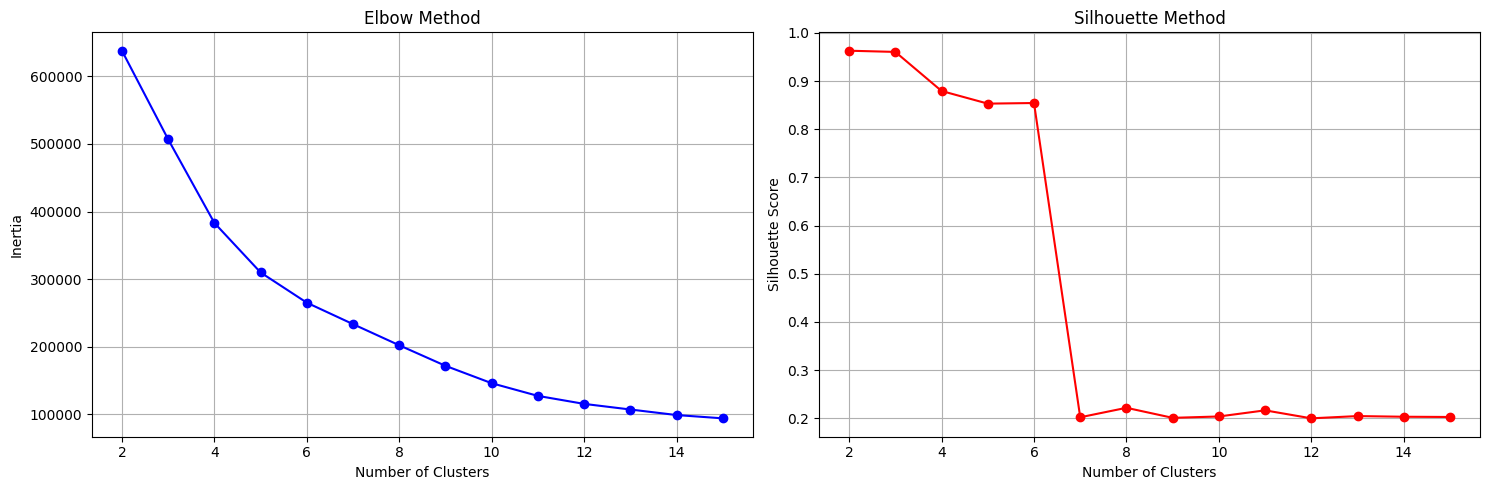

Suggested clusters by Elbow method: 2
Suggested clusters by Silhouette method: 2

3. APPLYING CLUSTERING WITH 2 CLUSTERS...

K-MEANS CLUSTERING

HIERARCHICAL CLUSTERING

DBSCAN CLUSTERING

KMEANS Evaluation:
Silhouette Score: 0.963
Davies-Bouldin Index: 0.504

HIERARCHICAL Evaluation:
Silhouette Score: 0.969
Davies-Bouldin Index: 0.313

DBSCAN found 12 clusters
Noise points: 7981

4. ANALYZING AND INTERPRETING CLUSTERS...

CLUSTER INTERPRETATIONS

📊 CLUSTER 0 - 8935 customers (99.8%)
----------------------------------------
Type: Cash Advance Users
Description: Relies heavily on cash advances. May indicate financial stress.

Key Statistics (mean values):
  • Balance: $1,393
  • Purchases: $737
  • Cash Advances: $674
  • Credit Limit: $4,421
  • Payments: $1,348

Derived Metrics:
  • Credit Utilization: 31.5%
  • Purchase to Balance Ratio: 0.53

📊 CLUSTER 1 - 15 customers (0.2%)
----------------------------------------
Type: High Spenders / Good Payer
Description: Makes frequent purcha

In [16]:
def customer_clustering_pipeline(filepath):
    """Complete end-to-end clustering pipeline"""

    print("="*60)
    print("CUSTOMER CLUSTERING PIPELINE")
    print("="*60)

    # 1. Load and preprocess
    print("\n1. LOADING AND PREPROCESSING DATA...")
    df = pd.read_csv(filepath)
    scaled_data, df_clean, cust_ids, scaler = preprocess_data(df)

    # 2. Determine optimal clusters
    print("\n2. DETERMINING OPTIMAL NUMBER OF CLUSTERS...")
    optimal_k = find_optimal_clusters(scaled_data)

    # 3. Apply clustering
    print(f"\n3. APPLYING CLUSTERING WITH {optimal_k} CLUSTERS...")
    results = apply_clustering(scaled_data, n_clusters=optimal_k)

    # 4. Analyze results
    print("\n4. ANALYZING AND INTERPRETING CLUSTERS...")
    df_labeled, profiles = interpret_clusters(
        df_clean,
        results['kmeans']['labels'],
        optimal_k
    )

    # 5. Create final summary
    print("\n" + "="*60)
    print("FINAL RECOMMENDATIONS")
    print("="*60)

    # ----------- PARAPHRASED TEXT BELOW -----------
    print("\nBUSINESS IMPLICATIONS:")
    print("- Mengidentifikasi pelanggan bernilai tinggi untuk difokuskan dalam upaya retensi")
    print("- Menemukan pelanggan berisiko yang memerlukan penyesuaian batas kredit")
    print("- Mengarahkan kampanye pemasaran berdasarkan pola pengeluaran pelanggan")
    print("- Menyempurnakan batas penarikan tunai sesuai kebiasaan penggunaan")

    print("\nNEXT STEPS:")
    print("1. Mengonfirmasi hasil klaster dengan pemangku kepentingan bisnis")
    print("2. Memantau bagaimana klaster berubah dari waktu ke waktu")
    print("3. Mengembangkan model prediktif khusus untuk masing-masing klaster")
    print("4. Merancang strategi intervensi yang sesuai untuk tiap segmen pelanggan")

    return {
        'data': df_labeled,
        'scaled_data': scaled_data,
        'profiles': profiles,
        'model': results['kmeans']['model'],
        'labels': results['kmeans']['labels']
    }

# Run complete pipeline
pipeline_results = customer_clustering_pipeline('clusteringmidterm.csv')